<a href="https://colab.research.google.com/github/jonbmartin/Gradient-Waveform-Errors-Demos/blob/main/Ex2_GIRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook walks through building a gradient impulse response function (GIRF) and applying the GIRF model to predict distortions in gradient waveforms.

This demo minimally adapts MATLAB code created by Johanna Vannesjo and Lars Kasper, two of the GIRF method authors (see https://github.com/MRI-gradient/GIRF for their implementation).

See this list of references:


In [ ]:
# installing a python package for RF/gradient pulse design utilities
!pip install pulpy
!pip install numpy==1.25

In [ ]:
import numpy as np
import pulpy.grad as pulpgrad
import matplotlib.pyplot as plt
import pylab as pylab
from scipy.fftpack import fft, ifft, fftfreq, fftshift

/usr/local/lib/python3.11/dist-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(


Ok, next let us build some test waveforms to build/evaluate the GIRF. We will construct a simple chirp waveform and a standard blip gradient.

In [ ]:
def chirp(t, f0, f1, T):
  # TODO: Slew rate limited chirp.
  """Generates a linear gradient chirp waveform.

  Args:
    t: Time vector.
    f0: Starting frequency.
    f1: Ending frequency.
    T: Duration of the chirp.

  Returns:|
    A numpy array representing the chirp waveform.
  """
  return np.sin(2 * np.pi * (f0 + (f1 - f0) / T * t) * t)

# Example usage
dt = 5e-6 # [s]
T = 0.5 # [s]
T_sweep = 0.05 # [s]
t = np.linspace(0, T_sweep, int(T_sweep/dt))
t_full = np.linspace(0, T, int(T/dt))

f0 = 0  # Starting frequency (Hz)
f1 = 300*10^3 # Ending frequency (Hz)
chirp_waveform = chirp(t, f0, f1, T_sweep)
# chirp_waveform_2 = chirp(t,f0,f1/10,T_sweep)

trap_waveform,_ = pulpgrad.trap_grad(area=1E-7, gmax=0.1, dgdt=20,dt=dt)
trap_waveform = trap_waveform/np.max(np.abs(trap_waveform))
print(np.shape(trap_waveform))


(1, 32)


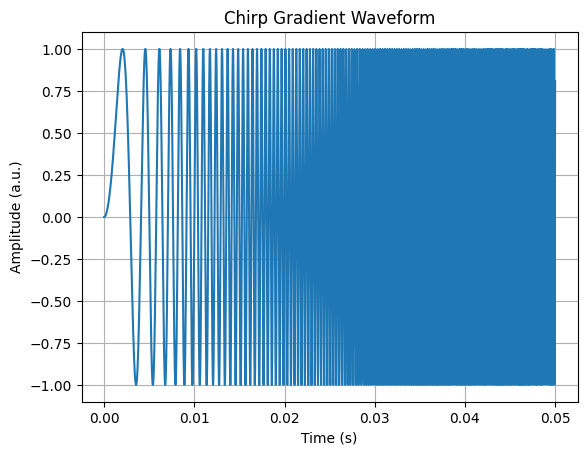

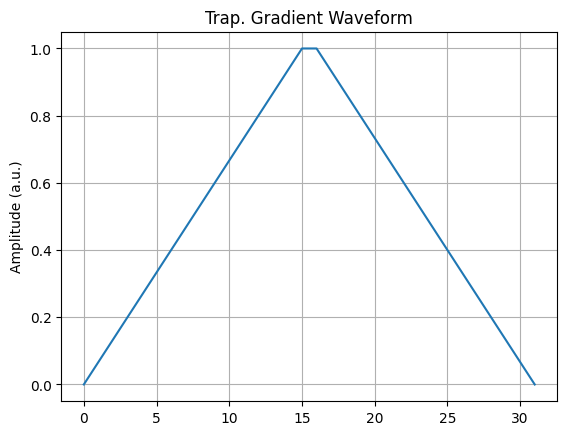

In [ ]:
# Plot the chirp waveform
plt.plot(t, chirp_waveform)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.title('Chirp Gradient Waveform')
plt.grid(True)
plt.show()

# Plot the blip waveform
plt.plot(np.squeeze(trap_waveform))
# plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.title('Trap. Gradient Waveform')
plt.grid(True)
plt.show()

Ok, next we simulate a very simple gradient hardware system. Let's say that our hardware just low-pass filters our input - a fairly realistic, linear distortion.

In [ ]:
chirp_waveform_padded = np.pad(chirp_waveform, (1000, len(t_full) - len(t)-1000))
small_chirp = np.roll(chirp_waveform_padded,50)
# chirp_waveform_2 = np.pad(chirp_waveform_2, (1000, len(t_full) - len(t)-1000))
trap_waveform_padded = np.pad(np.squeeze(trap_waveform), (1000, len(t_full) - len(np.squeeze(trap_waveform))-1000))
n_waveforms = 2

inTime = np.stack((chirp_waveform_padded, trap_waveform_padded, ), axis=1)
# add a small amount of noise to the input waveforms:
inTime = inTime + np.random.normal(0, 0.01, np.shape(inTime))*5e-4

inFreq = np.zeros(np.shape(inTime), dtype=complex)
outTime = np.zeros(np.shape(inTime), dtype=complex)
outFreq = np.zeros(np.shape(inTime), dtype=complex)

thresh = 6E3 # [Hz]
for ii in range(n_waveforms):
  signal = inTime[:,ii]
  W = fftfreq(signal.size, d=t[1]-t[0])
  f_signal = fft(signal)
  inFreq[:,ii] = fftshift(f_signal)

  # If our original signal time was in seconds, this is now in Hz
  cut_f_signal = f_signal.copy()
  cut_f_signal[(abs(W)<thresh)] = cut_f_signal[(abs(W)<thresh)] * (1-abs(W[(abs(W)<thresh)])/thresh)
  cut_f_signal[(abs(W)>thresh)] = 0
  outFreq[:,ii] = cut_f_signal

  cut_signal = ifft(cut_f_signal)
  outTime[:,ii] = cut_signal

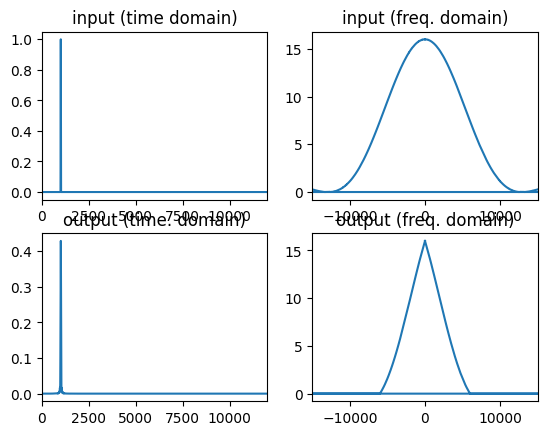

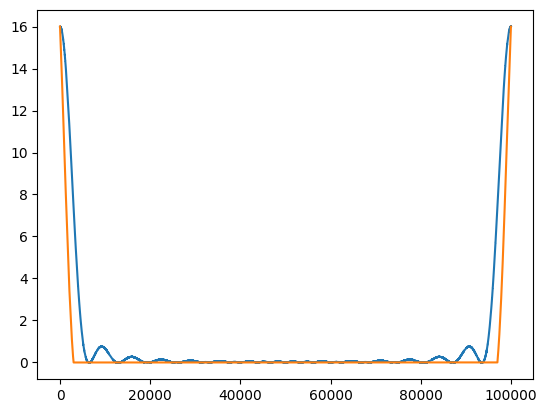

In [ ]:
pylab.subplot(221)
pylab.plot(signal)
pylab.xlim(0,12000)
pylab.title('input (time domain)')
pylab.subplot(222)
pylab.plot(W,np.abs(f_signal))

pylab.title('input (freq. domain)')
pylab.xlim(-1.5E4,1.5E4)
pylab.subplot(224)
pylab.plot(W,np.abs(cut_f_signal))
pylab.title('output (freq. domain)')
pylab.xlim(-1.5E4,1.5E4)
pylab.subplot(223)
pylab.plot(cut_signal)
pylab.xlim(0,12000)
pylab.title('output (time. domain)')
pylab.show()

plt.plot(np.abs(f_signal))
plt.plot(np.abs(cut_f_signal))
plt.show()


Next, we compute the GIRF:


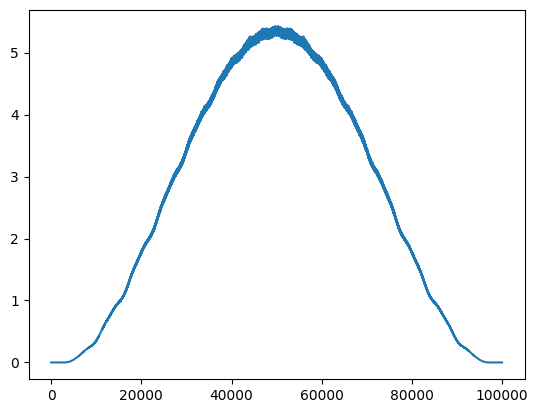

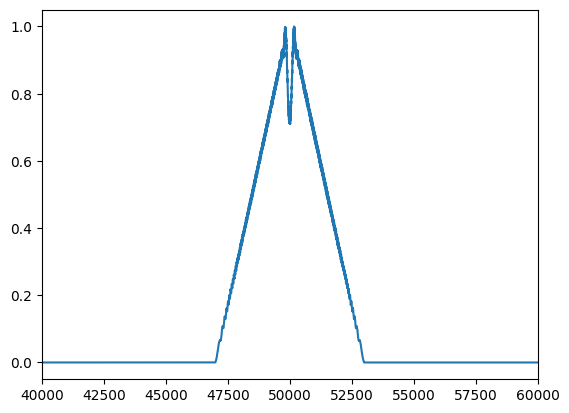

In [ ]:
# FFTshift
# inFreq = np.fft.fftshift(inFreq, axes=0)
# outFreq = np.fft.fftshift(outFreq, axes=0)
inFreq = np.fft.fftshift(inFreq, axes=0)
outFreq = np.fft.fftshift(outFreq, axes=0)
# perform least-squares estimation from the input
inSOSInv = 1/(np.sum(np.abs(inFreq)**2,axis=1))

girf = np.sum(outFreq*np.conj(inFreq),axis=1)*inSOSInv
girf = girf / np.max(np.abs(girf))


plt.plot(inSOSInv)
plt.show()
plt.plot(np.abs(girf))
plt.xlim([40000,60000])
plt.show()

Test the predictive power of our GIRF! We'll perform a frequency-domain application.

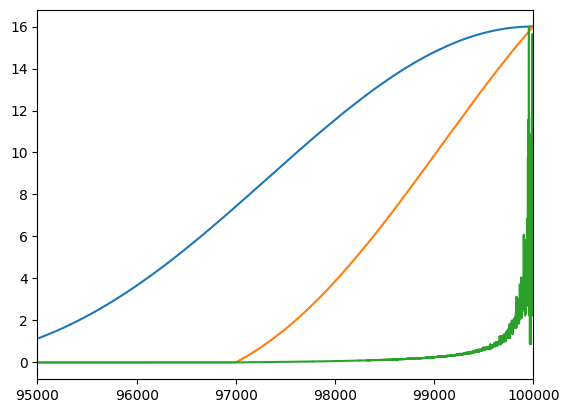

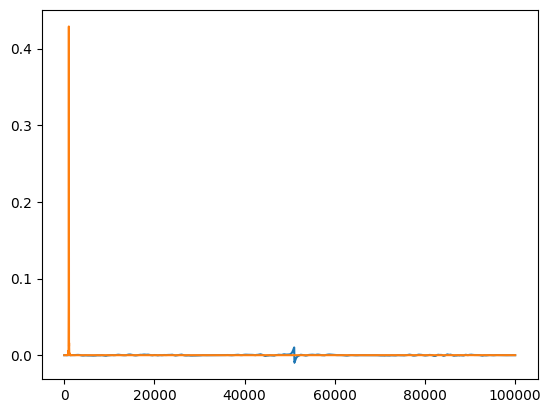

In [ ]:
H = girf

out_pred = np.zeros(np.shape(inFreq), dtype=complex)
for ii in range(n_waveforms):
  out_pred[:,ii] = H * fftshift(inFreq[:,ii])

pylab.plot(np.abs(fftshift((inFreq[:,1]))))
pylab.plot(np.abs((outFreq[:,1])))
pylab.plot(np.abs((out_pred[:,1])))
pylab.xlim(95000,100000)

pylab.show()
#pylab.plot(-np.roll(ifft(fftshift(out[:,0])),10000))
waveform_index_plotting = 1
pylab.plot(fftshift(np.real(ifft(out_pred[:,waveform_index_plotting]))))
pylab.plot(outTime[:,waveform_index_plotting])
pylab.show()
